Import library

In [ ]:
from bayes_opt import BayesianOptimization
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

from string import ascii_lowercase
from itertools import combinations

import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import  GradientBoostingClassifier

from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
import torch
from sklearn.model_selection import StratifiedKFold
from torch import nn, optim

from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from tqdm import tqdm

Load Data

In [ ]:
#train.csv, test.csv in Shareddrives
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

EDA

In [ ]:
train.head()

,index,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,...,engnat,age,hand,religion,orientation,voted,married,familysize,ASD,nerdiness
0,0,1.0,5.0,5.0,5.0,1.0,4.0,5.0,5.0,1.0,...,1.0,20,2.0,12.0,4.0,2.0,1.0,4.0,2.0,1
1,1,4.0,4.0,4.0,4.0,4.0,5.0,4.0,4.0,3.0,...,1.0,49,1.0,2.0,1.0,1.0,2.0,4.0,2.0,1
2,2,4.0,5.0,5.0,4.0,3.0,5.0,5.0,5.0,4.0,...,2.0,43,1.0,2.0,2.0,2.0,3.0,4.0,2.0,1
3,3,4.0,4.0,4.0,2.0,4.0,3.0,3.0,5.0,3.0,...,1.0,17,2.0,1.0,1.0,2.0,1.0,2.0,2.0,1
4,4,4.0,4.0,4.0,4.0,3.0,3.0,4.0,2.0,3.0,...,2.0,18,2.0,12.0,1.0,2.0,1.0,1.0,2.0,0


In [ ]:
test.head()

,index,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,...,gender,engnat,age,hand,religion,orientation,voted,married,familysize,ASD
0,0,4.0,4.0,3.0,5.0,5.0,5.0,3.0,5.0,4.0,...,2.0,2.0,19,1.0,4.0,4.0,1.0,1.0,3.0,2.0
1,1,4.0,5.0,4.0,4.0,5.0,4.0,5.0,5.0,5.0,...,1.0,1.0,33,1.0,1.0,5.0,2.0,1.0,5.0,2.0
2,2,5.0,5.0,5.0,5.0,4.0,5.0,5.0,5.0,5.0,...,2.0,2.0,13,1.0,4.0,5.0,2.0,1.0,3.0,2.0
3,3,5.0,4.0,3.0,4.0,5.0,4.0,5.0,4.0,4.0,...,1.0,1.0,28,1.0,2.0,2.0,2.0,1.0,3.0,2.0
4,4,5.0,5.0,5.0,5.0,5.0,3.0,5.0,5.0,5.0,...,2.0,2.0,15,1.0,4.0,5.0,2.0,1.0,2.0,2.0


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 70 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   index         15000 non-null  int64  
 1   Q1            14959 non-null  float64
 2   Q2            14931 non-null  float64
 3   Q3            14950 non-null  float64
 4   Q4            14929 non-null  float64
 5   Q5            14962 non-null  float64
 6   Q6            14952 non-null  float64
 7   Q7            14924 non-null  float64
 8   Q8            14952 non-null  float64
 9   Q9            14944 non-null  float64
 10  Q10           14928 non-null  float64
 11  Q11           14941 non-null  float64
 12  Q12           14933 non-null  float64
 13  Q13           14960 non-null  float64
 14  Q14           14964 non-null  float64
 15  Q15           14955 non-null  float64
 16  Q16           14967 non-null  float64
 17  Q17           14963 non-null  float64
 18  Q18           14937 non-nu

In [ ]:
cat_col = train.columns[train.dtypes == object]
for col in cat_col:
    print(train[col].value_counts())
    print('=' * 50)
  
cat_col = train.columns[train.dtypes != object]
for col in cat_col:
    print(train[col].value_counts())
    print('=' * 50)

USA    7419
GBR    1109
CAN     915
AUS     525
DEU     473
       ... 
PNG       1
MUS       1
MDV       1
GRL       1
ETH       1
Name: country, Length: 137, dtype: int64
0        1
10004    1
9992     1
9993     1
9994     1
        ..
5004     1
5005     1
5006     1
5007     1
14999    1
Name: index, Length: 15000, dtype: int64
5.0    5939
4.0    4924
3.0    2444
2.0    1055
1.0     597
Name: Q1, dtype: int64
5.0    7236
4.0    4129
3.0    1688
2.0    1067
1.0     811
Name: Q2, dtype: int64
5.0    7626
4.0    4788
3.0    1256
2.0     801
1.0     479
Name: Q3, dtype: int64
5.0    5512
4.0    4313
3.0    2564
2.0    1619
1.0     921
Name: Q4, dtype: int64
5.0    5619
4.0    4833
3.0    2153
2.0    1458
1.0     899
Name: Q5, dtype: int64
4.0    4846
5.0    4336
3.0    3238
2.0    1659
1.0     873
Name: Q6, dtype: int64
5.0    7584
4.0    4385
3.0    1581
2.0     854
1.0     520
Name: Q7, dtype: int64
5.0    6605
4.0    3888
3.0    1823
1.0    1319
2.0    1317
Name: Q8, dtype: int64
5

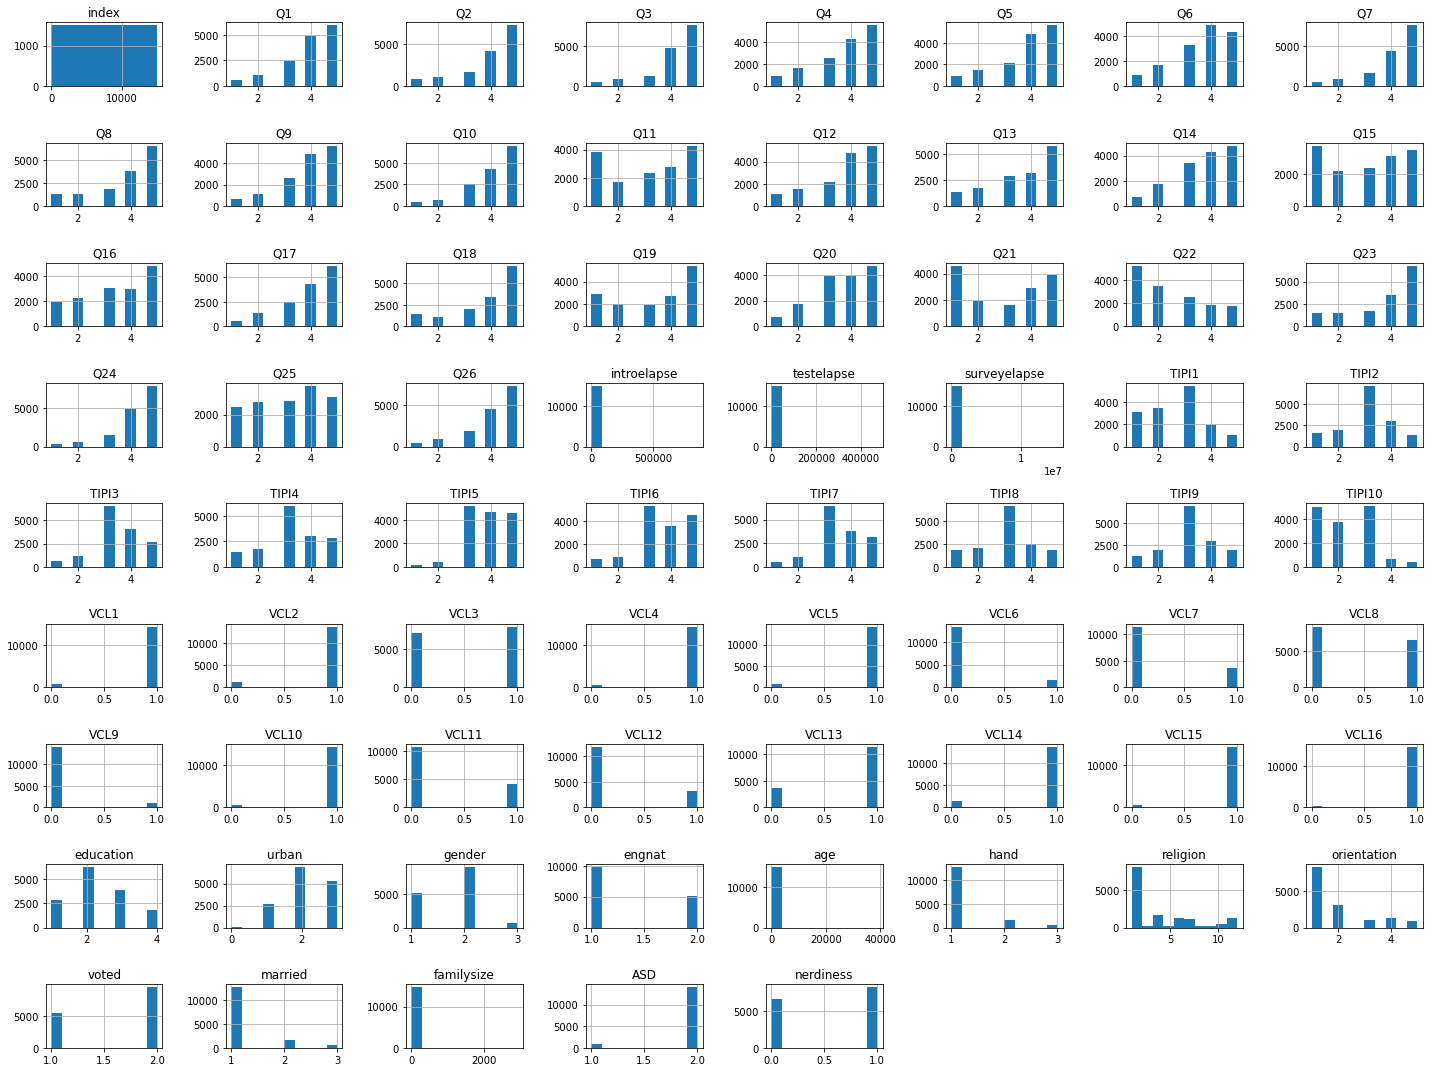

In [ ]:
train.hist(figsize=(20, 15))
plt.tight_layout()
plt.show()

'country'변수에서 빈도순 상위 90종을 제외한 값들은 모두 'etc' 처리

In [ ]:
import sklearn

country_lab=list(set(train['country'].value_counts().head(90).index))

for i in tqdm(range(len(train))):
  if train['country'][i] not in country_lab:
    train['country'][i]="etc"

for i in tqdm(range(len(test))):
  if test['country'][i] not in country_lab:
    test['country'][i]="etc"

  0%|          | 0/15000 [00:00<?, ?it/s]/var/folders/qq/6l87d0lj5fqfmc0nnx6fhm_w0000gn/T/ipykernel_16582/3634998559.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['country'][i]="etc"
  0%|          | 0/35452 [00:00<?, ?it/s]/var/folders/qq/6l87d0lj5fqfmc0nnx6fhm_w0000gn/T/ipykernel_16582/3634998559.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['country'][i]="etc"
100%|██████████| 35452/35452 [00:00<00:00, 233715.32it/s]


train_x : training data set에서 'nerdiness'와 'index'을 drop시킨 dataset

test : test data set에서 'index'을 drop시킨 dataset

In [ ]:
train_x=train
train_y=train['nerdiness']

train_x.drop(['index'], axis=1, inplace=True)
test.drop(['index'], axis=1, inplace=True)

percentile을 이용하여 'introelapse', 'testelapse', 'surveyelapse', 'age', 'familysize'변수의 outlier 처리

In [ ]:
def outlier(df, col, weight=1.5):
  q1=np.percentile(df[col].values, 25)
  q3=np.percentile(df[col].values, 75)

  iqr=q3-q1
  lb=q1-iqr*weight
  ub=q3+iqr*weight

  df.loc[df[col]>ub][col]=ub
  df.loc[df[col]<lb][col]=lb

  return df[col]

for col in ['introelapse', 'testelapse', 'surveyelapse', 'age', 'familysize']:
  train_x[col]=outlier(train_x, col)
  test[col]=outlier(test, col)

/var/folders/qq/6l87d0lj5fqfmc0nnx6fhm_w0000gn/T/ipykernel_16582/3089667295.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[col]>ub][col]=ub


'country', 'education', 'gender', 'engnat', 'hand', 'voted', 'married', 'ASD'변수의 결측치를 따로 구분하기 위해 '변수이름_isna'라는 새로운 변수를 생성

In [ ]:
erases = [ 'country', 'education', 'gender', 'engnat', 'hand', 'voted', 'married', 'ASD' ]
for i in erases:
  train_x[i+'_isna'] = (train_x[i]==np.nan)
  test[i+'_isna'] = (test[i]==np.nan)

'Q', 'TIPI'의 결측치를 3으로 imputation

'VCL'의 결측치를 각 변수의 최빈값으로 imputation

In [ ]:
for i in range(1, 27) :
  train_x['Q' + str(i)] = train_x['Q' + str(i)].fillna(3) #평균값, 보통이다 /0(답변안함) #3."보통이다"
  test['Q' + str(i)] = test['Q' + str(i)].fillna(3) #평균값, 보통이다 /0(답변안함) #3."보통이다"
  
for i in range(1, 11) :
  train_x['TIPI' + str(i)] = train_x['TIPI' + str(i)].fillna(3) #3."보통이다"
  test['TIPI' + str(i)] = test['TIPI' + str(i)].fillna(3) #3."보통이다"
  
for i in range(1, 17) :
  train_x['VCL' + str(i)] = train_x['VCL' + str(i)].fillna(train_x['VCL' + str(i)].mode()[0]) #최빈값
  test['VCL' + str(i)] = test['VCL' + str(i)].fillna(train_x['VCL' + str(i)].mode()[0]) #최빈값

'familysize'의 결측치를 mean의 반올림 결과로 채움

In [ ]:
modes = [] #최빈값으로 대체할 변수들
means = [ 'familysize' ] #평균으로 대체할 변수
for i in means:
  train_x[i] = train_x[i].fillna(round(train_x[i].mean()))
  test[i] = test[i].fillna(round(train_x[i].mean()))

'Q'변수들을 질문 특성별로 나누어 모두 더한 값을 나타낸 변수 'T'(Tactic), 'V'(View), 'M'(Morality) 추가

In [ ]:
train_x['T'] = train_x['Q1'] + train_x['Q2'] + train_x['Q3'] + train_x['Q7'] + train_x['Q10'] + train_x['Q12'] + train_x['Q15'] + train_x['Q16'] + train_x['Q6']
train_x['V'] = train_x['Q5'] + train_x['Q4'] + train_x['Q8'] + train_x['Q11'] + train_x['Q17'] + train_x['Q20'] + train_x['Q14'] + train_x['Q18']
train_x['M'] = train_x['Q9'] + train_x['Q19']

test['T'] = test['Q1'] + test['Q2'] + test['Q3'] + test['Q7'] + test['Q10'] + test['Q12'] + test['Q15'] + test['Q16'] + test['Q6'] 
test['V'] = test['Q5'] + test['Q4'] + test['Q8'] + test['Q11'] + test['Q17'] + test['Q20'] + test['Q14'] + test['Q18'] 
test['M'] = test['Q9'] + test['Q19']

모든 'Q' 변수 값들의 평균값을 나타내는 변수 'Mach_score' 추가

In [ ]:
questions = [i for i in range(1,27)]
answers = [('Q'+str(i)) for i in questions]
answers

train_x['Mach_score'] = train_x[answers].mean(axis = 1)
test['Mach_score'] = test[answers].mean(axis = 1)

'VCL6', 'VCL9, 'VCL12' 변수는 허구 단어이기 때문에, 해당 단어의 정의를 안다고 표시한 정도를 나타내는 'lier' 변수를 생성

In [ ]:
train_x['lier']= train_x['VCL6']+train_x['VCL9']+train_x['VCL12']
test['lier']= test['VCL6']+test['VCL9']+test['VCL12']

'TIPI' 변수들을 질문 특성별로 나누어 표현한 'Ex'(Extraversion), 'Ag'(Agreeableness), 'Con'(Conscientiousness), 'Es'(Emotional stability), 'Op'(Openness)변수를 추가

In [ ]:
train_x['Ex'] = train_x['TIPI1']-train_x['TIPI6']
train_x['Ag'] = train_x['TIPI7']-train_x['TIPI2']
train_x['Con'] = train_x['TIPI3']-train_x['TIPI8']
train_x['Es'] =train_x['TIPI9']-train_x['TIPI4']
train_x['Op'] =train_x['TIPI5']-train_x['TIPI10']

test['Ex'] = test['TIPI1']-test['TIPI6']
test['Ag'] = test['TIPI7']-test['TIPI2']
test['Con'] = test['TIPI3']-test['TIPI8']
test['Es'] =test['TIPI9']-test['TIPI4']
test['Op'] =test['TIPI5']-test['TIPI10']

categorical feature 변수('country', 'urban', 'gender', 'engnat', 'hand', 'religion', 'orientation',  'voted', 'married')들 한정의 One-Hot Encoding을 진행

In [ ]:
cat_vals=['country', 'urban', 'gender', 'engnat', 'hand', 'religion', 'orientation',  'voted', 'married']
train_x=pd.get_dummies(train_x, columns = cat_vals)
test=pd.get_dummies(test, columns = cat_vals)

train_x와 test의 column 확인

In [ ]:
set(train_x.columns)==set(test.columns)

False

'age'변수 값이 18 이상이면 1, 미만이면 0을 나타내는 변수 'is_adult' 추가

In [ ]:
import numpy as np
train_x['is_adult'] = (train_x['age'] >= 18)
test['is_adult'] = (test['age'] >= 18)

train_x와 test의 남은 결측치들을 각 변수의 평균값으로 imputation

In [ ]:
train_x=train_x.fillna(train_x.mean(axis=0))
test=test.fillna(test.mean(axis=0))

'introelapse', 'testelapse', 'surveyelapse' 변수에 Log-Scaling을 적용

/Users/chlee/miniforge3/envs/lower_ver/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/chlee/miniforge3/envs/lower_ver/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/chlee/miniforge3/envs/lower_ver/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a fi

introelapseSkewness: 1.457
introelapseKurtosis: 2.180
testelapseSkewness: 3.791
testelapseKurtosis: 32.047
surveyelapseSkewness: 4.283
surveyelapseKurtosis: 53.794


/Users/chlee/miniforge3/envs/lower_ver/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/chlee/miniforge3/envs/lower_ver/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


introelapseSkewness: 1.422
introelapseKurtosis: 2.015
testelapseSkewness: 3.788
testelapseKurtosis: 30.750
surveyelapseSkewness: 5.273
surveyelapseKurtosis: 60.688


/Users/chlee/miniforge3/envs/lower_ver/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


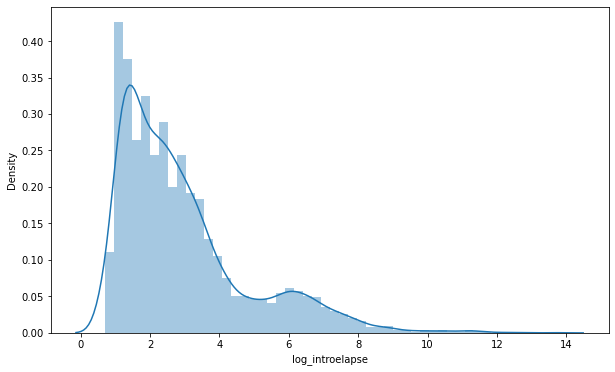

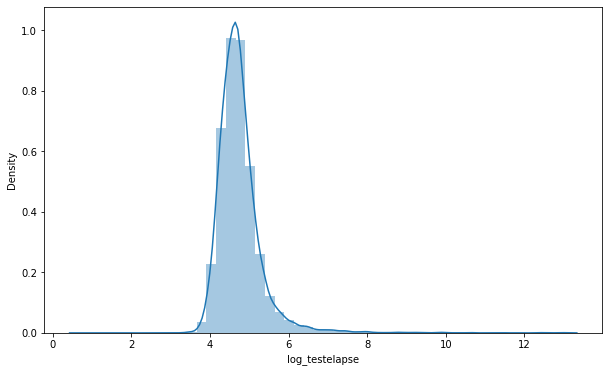

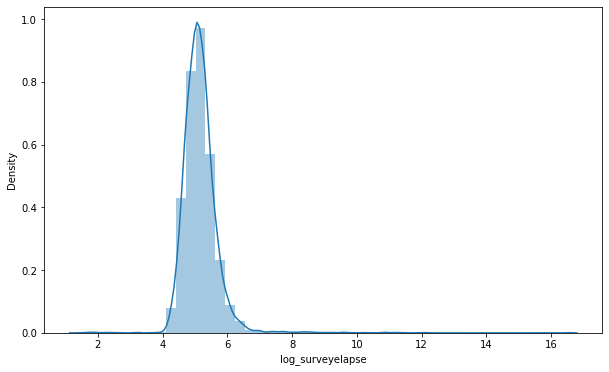

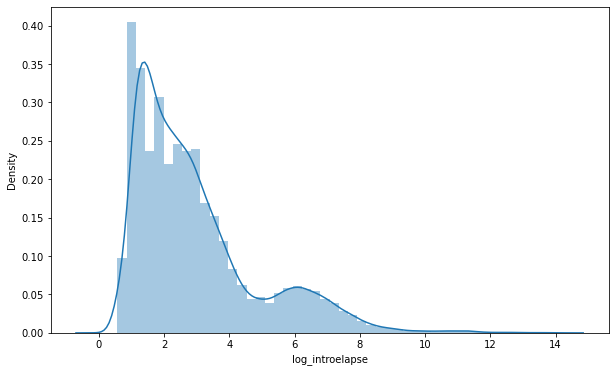

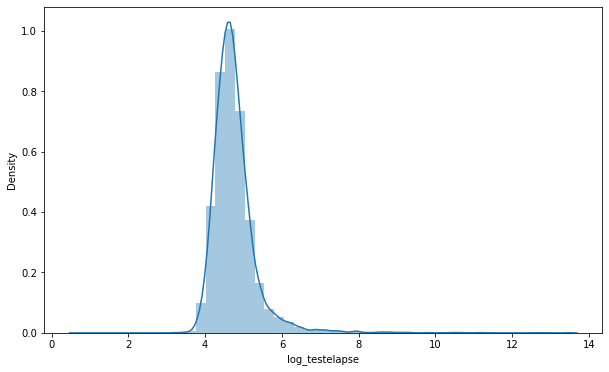

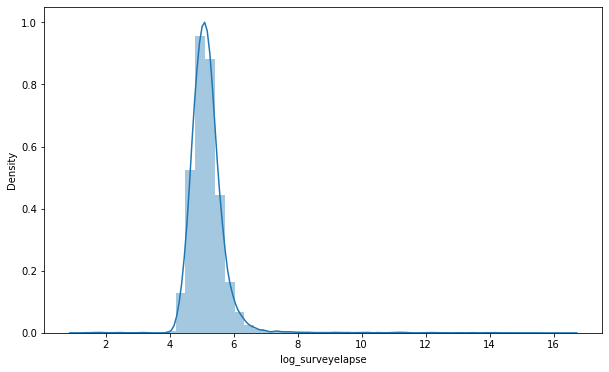

In [ ]:
logscales = ['introelapse', 'testelapse', 'surveyelapse']

for i in logscales:
  train_x["log_" + i] = np.log1p(train_x[i])
  f, ax = plt.subplots(figsize = (10, 6))
  sns.distplot(train_x["log_" + i])
  
  print( i + "Skewness: {:.3f}".format(train_x["log_" + i].skew()))
  print( i + "Kurtosis: {:.3f}".format(train_x["log_" + i].kurt()))

for i in logscales:
  test["log_" + i] = np.log1p(test[i])
  f, ax = plt.subplots(figsize = (10, 6))
  sns.distplot(test["log_" + i])
  
  print( i + "Skewness: {:.3f}".format(test["log_" + i].skew()))
  print( i + "Kurtosis: {:.3f}".format(test["log_" + i].kurt()))

for i in logscales:
  train_x.drop(i, axis=1, inplace = True)
  test.drop(i, axis=1, inplace = True)

In [ ]:
#pycaret automl
import jinja2
import numpy as np
import sklearn
from pycaret.classification import *

데이터 준비 

In [ ]:
setup_clf = setup(data=train_x, target='nerdiness', train_size=0.7, 
                  normalize=False,
                  session_id=777)

,Description,Value
0,Session id,777
1,Target,nerdiness
2,Target type,Binary
3,Original data shape,"(15000, 204)"
4,Transformed data shape,"(15000, 196)"
5,Transformed train set shape,"(10499, 196)"
6,Transformed test set shape,"(4501, 196)"
7,Numeric features,194
8,Preprocess,True
9,Imputation type,simple


모델 준비

In [ ]:
model = compare_models(sort='auc', fold = 5, n_select=3)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.7645,0.8531,0.8269,0.7663,0.7953,0.5191,0.5215,0.2900
rf,Random Forest Classifier,0.7635,0.8490,0.8276,0.7647,0.7948,0.5167,0.5193,0.2880
xgboost,Extreme Gradient Boosting,0.7511,0.8200,0.8059,0.7593,0.7819,0.4927,0.4940,1.2060
lightgbm,Light Gradient Boosting Machine,0.7465,0.8191,0.8099,0.7516,0.7796,0.4824,0.4844,0.1280
gbc,Gradient Boosting Classifier,0.7367,0.8043,0.8045,0.7419,0.7718,0.4619,0.4643,0.7780
lr,Logistic Regression,0.7231,0.7935,0.7896,0.7316,0.7594,0.4344,0.4364,1.2120
lda,Linear Discriminant Analysis,0.7221,0.7924,0.7959,0.7276,0.7601,0.4313,0.4340,0.1220
ada,Ada Boost Classifier,0.7235,0.7923,0.7890,0.7322,0.7594,0.4354,0.4373,0.2640
knn,K Neighbors Classifier,0.6940,0.7481,0.7466,0.7140,0.7298,0.3774,0.3780,0.3200
dt,Decision Tree Classifier,0.6924,0.6888,0.7216,0.7224,0.7220,0.3776,0.3777,0.1000


Processing:   0%|          | 0/67 [00:00<?, ?it/s]

모델 튜닝 및 앙상블

In [ ]:
tuned_model = [tune_model(i) for i in model]

blended_model = blend_models(estimator_list=tuned_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6819,0.7592,0.7487,0.6982,0.7226,0.3509,0.3521
1,0.7019,0.7656,0.7866,0.7074,0.7449,0.3888,0.3920
2,0.7276,0.7951,0.7917,0.7360,0.7629,0.4439,0.4456
3,0.7095,0.7827,0.7849,0.7170,0.7494,0.4056,0.4080
4,0.7486,0.8177,0.8382,0.7412,0.7868,0.4833,0.4887
5,0.7276,0.7960,0.8141,0.7266,0.7679,0.4409,0.4451
6,0.7229,0.7903,0.8003,0.7266,0.7617,0.4325,0.4353
7,0.7048,0.7795,0.8282,0.6965,0.7567,0.3884,0.3979
8,0.7200,0.7868,0.8265,0.7136,0.7659,0.4222,0.4293


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6895,0.7597,0.7883,0.6929,0.7375,0.3614,0.3659
1,0.7057,0.7725,0.8193,0.7000,0.7550,0.3923,0.3999
2,0.7286,0.7976,0.8434,0.7164,0.7747,0.4390,0.4483
3,0.7152,0.7841,0.8090,0.7143,0.7587,0.4147,0.4195
4,0.7438,0.8218,0.8709,0.7229,0.7900,0.4687,0.4822
5,0.7210,0.7990,0.8417,0.7087,0.7695,0.4225,0.4326
6,0.7248,0.7935,0.8279,0.7179,0.7690,0.4328,0.4396
7,0.6981,0.7781,0.8454,0.6843,0.7563,0.3710,0.3855
8,0.7267,0.7936,0.8660,0.7069,0.7784,0.4312,0.4465


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7057,0.7918,0.9208,0.6704,0.7759,0.3769,0.4191
1,0.6933,0.8000,0.9225,0.6593,0.7690,0.3485,0.3947
2,0.7219,0.8246,0.9277,0.6831,0.7869,0.4123,0.4540
3,0.7133,0.8009,0.9277,0.6754,0.7817,0.3930,0.4371
4,0.7143,0.8410,0.9552,0.6695,0.7872,0.3910,0.4525
5,0.7019,0.8155,0.9312,0.6646,0.7756,0.3666,0.4157
6,0.7048,0.8341,0.9398,0.6650,0.7789,0.3717,0.4255
7,0.6914,0.7992,0.9364,0.6550,0.7709,0.3410,0.3960
8,0.7038,0.8165,0.9467,0.6631,0.7799,0.3676,0.4263


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7705,0.8491,0.8055,0.7852,0.7952,0.5342,0.5345
1,0.7438,0.8423,0.8090,0.7484,0.7775,0.4767,0.4787
2,0.7781,0.8616,0.8055,0.7959,0.8007,0.5504,0.5505
3,0.7714,0.8546,0.8262,0.7754,0.8000,0.5340,0.5354
4,0.8181,0.9016,0.8812,0.8076,0.8428,0.6280,0.6313
5,0.7762,0.8677,0.8399,0.7746,0.8059,0.5426,0.5451
6,0.7800,0.8702,0.8554,0.7717,0.8114,0.5491,0.5533
7,0.7724,0.8649,0.8557,0.7626,0.8065,0.5324,0.5376
8,0.7781,0.8578,0.8643,0.7656,0.8119,0.5437,0.5497


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

모델 성능평가

In [ ]:
final_model = finalize_model(blended_model)
evaluate_model(final_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [ ]:
from pycaret.utils import check_metric

prediction = predict_model(final_model, data=train_x[train_x.columns.drop('nerdiness')])

print("테스트셋 정확도: "+str(check_metric(prediction['Label'], train_x['nerdiness'], metric = 'AUC')))

테스트셋 정확도: 1.0


test set으로 최종 predict

In [ ]:
test_2 = pd.read_csv('test.csv')

index = test_2['index']

model = final_model

#확률로 예측
pred_y = model.predict_proba(test)
pred_y = pred_y[:,1]

print(pred_y[:5])
submission_2 = pd.DataFrame({
    "index" : index,
    "nerdiness" : pred_y
})

[0.17647919 0.87070468 0.85781681 0.71464194 0.87644393]


predict 결과값이 0.9 초과이면 1, 0.1 미만이면 0으로 수정

In [ ]:
submission_2.loc[submission_2['nerdiness']>0.9, 'nerdiness'] = 1

In [ ]:
submission_2.loc[submission_2['nerdiness']<0.1, 'nerdiness'] = 0

최종 엑셀 파일 저장

In [ ]:
submission_2.to_csv('submission0825_pycaret2+logscale_2.csv', index=False)